In [1]:
import numpy as np
import random as ran
import numpy.random as npr
import numpy.fft as nft
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import matplotlib.colors as mcl

plt.rcParams["axes.linewidth"]  = 2
plt.rcParams["xtick.major.size"]  = 8
plt.rcParams["xtick.minor.size"]  = 3
plt.rcParams["ytick.major.size"]  = 8
plt.rcParams["ytick.minor.size"]  = 3
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams.update({'font.size': 24})

c1=mcm.Dark2(np.linspace(0,1,9))
c2=mcm.Set2(np.linspace(0,1,9))

### This section is about reading NoF number of lightcurves stored in a folder named objct located in the same directory. The paths of these lightcurves are listed in the path.txt located inside objct. The lbl and instru can be used to record the time this observation took place and the telescope used.
  


In [2]:
objct=input('Enter object name:')
paths=np.genfromtxt(objct+'/path.txt',dtype=str,usecols=0)
lbl=np.genfromtxt(objct+'/path.txt',dtype=str,usecols=2)
instru=np.genfromtxt(objct+'/path.txt',dtype=str,usecols=1)
NoF=len(paths)

Enter object name:Mrk421


### M (should be 2**n) is the length of the the "super"  lightcurve from which R lightcurves are divided into using the the Timmer-Kroenig algorithm. M should  depend on R(=200 when I use) and typical number of data points in each lightcurve. A large value like M=2097152 can be used but that can make things inefficient. I used trial&error to narrow to M=524288 for the lightcurves in my study.     


In [3]:
#M=65536
M=131072
#M=262144
#M=524288
#M=1048576
#M=2097152
N_sim=200

### Some important lists and variables chi-stores chi-square values           
hdr-stores best-fit parameters         
guess-parameter space for searching    
   best PSD normalization           
pl_ind-parameter search for searching  
    best fit PSD slope              
sucssf-stores success fractions        
max_ind-stores index of best fit slope 



In [14]:
chi=np.zeros((NoF,N_sim+1))
hdr=np.empty((NoF,6))
guess=np.arange(-15,0,0.005)
J=len(guess)
pl_ind=np.arange(1.0,3.0,0.05)
K=len(pl_ind)
sucssf=np.zeros((NoF,K))
max_ind=np.zeros(NoF)

In [5]:
def least_div(X,N):
    dt=min(np.diff(X))
    nabla=(np.ceil(time[-1]) - np.floor(time[0])) /dt
    return(int(np.ceil(nabla)),dt)

### Calculation of PSD for SIMULATED lightcurve without rms normalization 
X-input light curve            
T-corresponding time array     
    RETURNS:                
Y-PSD for X                    


In [6]:
def powspec(X,T,F):
        L,P = len(X),len(F)
        #if L%2==0: P=int(L/2)
        #else:      P=int((L-1)/2)

        totT=T[-1] - T[0]       
        #F = np.linspace(1.0/totT,(1.0*P)/totT,P)
        Y = np.zeros(P)
        
        pi2=2*np.pi
        X-=np.mean(X)
        normlz=2.0*totT/(L*L)

        for k in range(P):
            Q=np.sum(X * np.cos(pi2*F[k]*T))
            R=np.sum(X * np.sin(pi2*F[k]*T))
            Y[k]= (Q*Q + R*R)*normlz

        return(Y)

### Calculation of PSD for OBSERVED lightcurve with rms normalization 
 X-input lightcurve         
 T-corresponding time array 
        RETURNS:            
 Y-PSD for X                


In [7]:
def powspec_obs(X,T,F):
        L,P = len(X),len(F)
        #if L%2==0: P=int(L/2)
        #else:      P=int((L-1)/2)

        totT=T[-1] - T[0]       
        #F = np.linspace(1.0/totT,(1.0*P)/totT,P)
        Y = np.zeros(P)
        
        pi2=2*np.pi
        mu=np.mean(X)
        X-=mu
        normlz=2.0*totT/(L*L*mu*mu)

        for k in range(P):
            Q=np.sum(X * np.cos(pi2*F[k]*T))
            R=np.sum(X * np.sin(pi2*F[k]*T))
            Y[k]= (Q*Q + R*R)*normlz
        return(Y)

### Generates shape of simulated PSD
 x-frequency                    
 a-simple power law slope       

        RETURNS:         
 S-PSD at frequency x    

In [8]:
def ps_shape(x,a):
    if x< 3.2e-6:  
         return((3.2e-6)**(-a[0]))
    if x>=3.2e-6:  
         return(np.power(x,-a[0]))
'''
def ps_shape(x,a):
    c=1e-6
    return (x**(-1.0)) /(1 + (x/c)**(-1.0+a[0]))'''

'\ndef ps_shape(x,a):\n    c=1e-6\n    return (x**(-1.0)) /(1 + (x/c)**(-1.0+a[0]))'

### Bins and interpolates simulated lightcurves in the same scheme  
V-input simulated lightcurve 
U-masking array              
RETURNS:           
V-resampled lightcurve       


### Bins and interpolates between gaps of the observed light curve  
X-observed light curve              
X-corresponding time array          
Q-new time interval for resampling 
RETURNS:      
U-masking array         
V-resampled light curve 
Y-time intervals for Y  
L- size of U,V,Y        
     

In [9]:
def resample(V,U):
    L=len(V)

    for i in range(L-1):
        a=V[i-1]
        if U[i]==0:
            k=1
            while (i+k)<L:
                if U[i+k]!=0:
                    b=V[i+k]
                    break
                k+=1
            m=(b-a)/(k+2)
            for l in range(i,i+k):  V[l]=a+m*(l-i+1)
            i=k
    return(V)

def bin_intp(X,T,dt):
    Y=np.arange(np.floor(T[0]),np.ceil(T[-1]),dt)
    L=len(Y)
    U=np.zeros(L)
    V=np.zeros(L)
    V[-1],U[-1]=X[-1],1
    
    for i in range(L-1):
        W=np.where((T>=Y[i])&(T<Y[i+1]))[0]
        if np.any(W)==True:
            V[i]=np.mean(X[W])
            U[i]=1
    
    V=resample(V,U)
    Y+=0.5*dt
    
    '''plt.plot(T,X)
    plt.scatter(Y,V,color='black')
    plt.show()'''
    
    return(L,U,V,Y)

### Generates R simulated light curves of given shape using the Timmer-Kroenig algorithm               
g-power law slope                                       
FG-frequency array                                      
U-masking array                                         
    RETURNS:                                        
V-R simulated light curves in the form of RxP matrix   


In [10]:
rndraws=npr.normal(0,1,M)
def timmkron(g,FG,U):
        L=int(M/2)
        norm=L*np.sqrt(FG[0])
        Z=np.zeros(L+1,dtype=complex)
        V=np.zeros((N_sim,Q))

        for i in range(1,L): Z[i]=norm * np.sqrt(ps_shape(FG[i-1],g)) * (rndraws[i]+1j*rndraws[M-i])
            
        Z[0],Z[L]= 0+0j,norm * np.sqrt(ps_shape(FG[L-1],g)) * (rndraws[0]+0j)
        W=nft.irfft(Z,n=M) 
        
        p0=0
        p1=Q+50
        '''
        plt.plot(range(M),W)
        plt.show()
        '''
        for k in range(N_sim):
            V[k,:]=resample(W[p0:p0+Q],U)
            p0+=p1
        return(V)


### Bins observed PSD- calculates mean and rms      
data-observed PSD                                       
bin_mem-indexing from linear to log bins of frequency  
N_bin-number of bins                                       
RETURNS:                                        
param-mean and rms of PSD in each frequency bin       


In [11]:
def binmeanstd_1D(data,bin_mem,N_bin):
    param=np.zeros((2,N_bin))

    for j in range(N_bin): 
        param[0,j]=np.log10(np.mean(data[bin_mem[j]])) + 0.253
        param[1,j]=np.std(np.log10(data[bin_mem[j]])-param[0,j],ddof=1)

    return(param)
  

### Bins simulated PSDs- calculates mean and rms      
data-R simulated PSD                                   
bin_mem- bin_mem from linear to log bins of frequency 
N_bin-number of bins                                       
RETURNS:        
mean_bin-binned PSD
param-mean and rms of all binned PSDs         


In [12]:
def binmeanstd_2D(data,bin_mem,N_bin):
    param=np.zeros((2,N_bin))
    mean_bin=np.zeros((N_sim,N_bin))

    for j in range(N_bin): 
        mean_bin[:,j]=np.log10(np.mean(data[1:,bin_mem[j]],axis=1)) + 0.253
        param[0,j]=np.mean(mean_bin[:,j])
        param[1,j]=np.std(mean_bin[:,j],ddof=1)

    return(mean_bin,param) 

Filename: pn2000.dat
Data size: 310 Time(in s) 32400.0
Smallest sampling interval(in s) 96.0 for which the data size is: 338
-------------------------------------------------------------------------------
 
New binned data size: 270 ,New sampling interval(in s) 120
Min frequency(in Hz): 3.0978934324659233e-05 ,Max frequency(in Hz): 0.004182156133828996
Min frequency(in Hz): 6.357828776041667e-08 ,Max frequency(in Hz): 0.004166666666666667
-------------------------------------------------------------------------------
 
Normalised poisson noise: 0.01581524087010344


/Users/bhattacharyya.37/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bhattacharyya.37/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1.000,-4.335,0.020
1.050,-4.480,0.020
1.100,-4.630,0.025
1.150,-4.780,0.030
1.200,-4.925,0.040
1.250,-5.075,0.055
1.300,-5.230,0.065
1.350,-5.380,0.105
1.400,-5.535,0.155
1.450,-5.685,0.190
1.500,-5.840,0.290
1.550,-5.990,0.400
1.600,-6.145,0.490
1.650,-6.295,0.570
1.700,-6.445,0.660
1.750,-6.600,0.730
1.800,-6.750,0.815
1.850,-6.910,0.875
1.900,-7.075,0.925
1.950,-7.240,0.955
2.000,-7.415,0.980
2.050,-7.595,0.985
2.100,-7.780,0.985
2.150,-7.975,0.995
2.200,-8.170,1.000
2.250,-8.375,1.000
2.300,-8.580,1.000
2.350,-8.790,1.000
2.400,-9.005,1.000
2.450,-9.225,1.000
2.500,-9.450,1.000
2.550,-9.670,1.000
2.600,-9.900,0.995
2.650,-10.130,0.995
2.700,-10.365,0.995
2.750,-10.600,0.990
2.800,-10.840,0.995
2.850,-11.080,0.995
2.900,-11.320,0.990
2.950,-11.565,0.990
Filename: pn2001.dat
Data size: 374 Time(in s) 37496.0
Smallest sampling interval(in s) 96.0 for which the data size is: 391
-------------------------------------------------------------------------------
 
New binned data size: 313 

/Users/bhattacharyya.37/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bhattacharyya.37/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1.000,-4.465,0.300
1.050,-4.615,0.360
1.100,-4.765,0.405
1.150,-4.915,0.455
1.200,-5.070,0.495
1.250,-5.220,0.515
1.300,-5.375,0.570
1.350,-5.530,0.610
1.400,-5.680,0.620
1.450,-5.835,0.625
1.500,-5.990,0.640
1.550,-6.150,0.665
1.600,-6.310,0.695
1.650,-6.480,0.735
1.700,-6.650,0.765
1.750,-6.830,0.815
1.800,-7.020,0.875
1.850,-7.220,0.900
1.900,-7.410,0.915
1.950,-7.615,0.925
2.000,-7.820,0.945
2.050,-8.025,0.960
2.100,-8.235,0.960
2.150,-8.445,0.970
2.200,-8.660,0.975
2.250,-8.875,0.985
2.300,-9.095,0.985
2.350,-9.315,0.990
2.400,-9.535,0.990
2.450,-9.760,0.985
2.500,-9.985,0.985
2.550,-10.215,0.980
2.600,-10.445,0.985
2.650,-10.675,0.985
2.700,-10.910,0.970
2.750,-11.145,0.970
2.800,-11.385,0.970
2.850,-11.625,0.970
2.900,-11.860,0.955
2.950,-12.100,0.945
Filename: pn2002.dat
Data size: 368 Time(in s) 36704.0
Smallest sampling interval(in s) 96.0 for which the data size is: 383
-------------------------------------------------------------------------------
 
New binned data size: 30

/Users/bhattacharyya.37/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bhattacharyya.37/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1.000,-4.355,0.670
1.050,-4.505,0.730
1.100,-4.655,0.785
1.150,-4.810,0.820
1.200,-4.960,0.880
1.250,-5.115,0.910
1.300,-5.270,0.935
1.350,-5.425,0.945
1.400,-5.580,0.945
1.450,-5.735,0.950
1.500,-5.895,0.955
1.550,-6.055,0.950
1.600,-6.225,0.955
1.650,-6.395,0.965
1.700,-6.570,0.970
1.750,-6.755,0.970
1.800,-6.945,0.970
1.850,-7.140,0.975
1.900,-7.345,0.985
1.950,-7.550,0.985
2.000,-7.760,0.990
2.050,-7.975,0.990
2.100,-8.190,0.990
2.150,-8.410,0.995
2.200,-8.630,0.995
2.250,-8.855,0.995
2.300,-9.080,0.995
2.350,-9.310,0.990
2.400,-9.540,0.990
2.450,-9.775,0.995
2.500,-10.010,0.995
2.550,-10.245,1.000
2.600,-10.485,1.000
2.650,-10.725,0.995
2.700,-10.965,0.990
2.750,-11.205,0.995
2.800,-11.450,0.990
2.850,-11.690,0.995
2.900,-11.940,0.995
2.950,-12.185,1.000


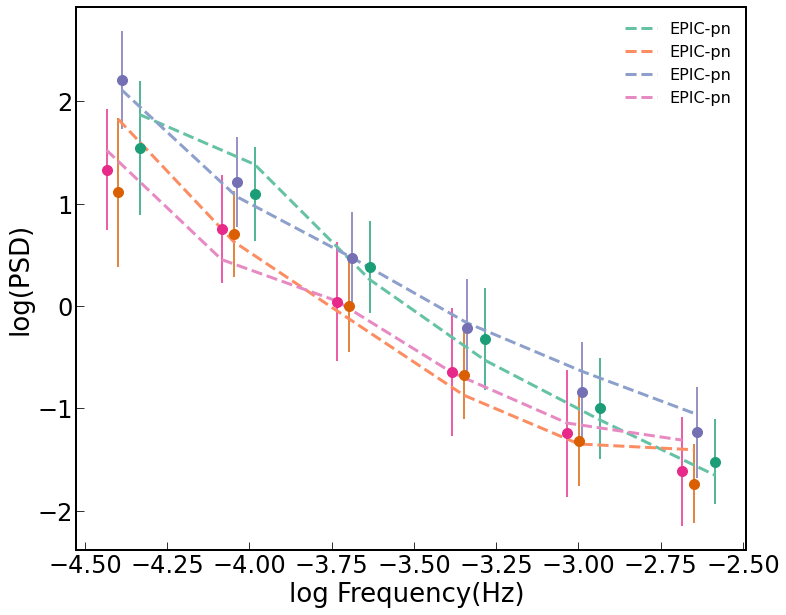

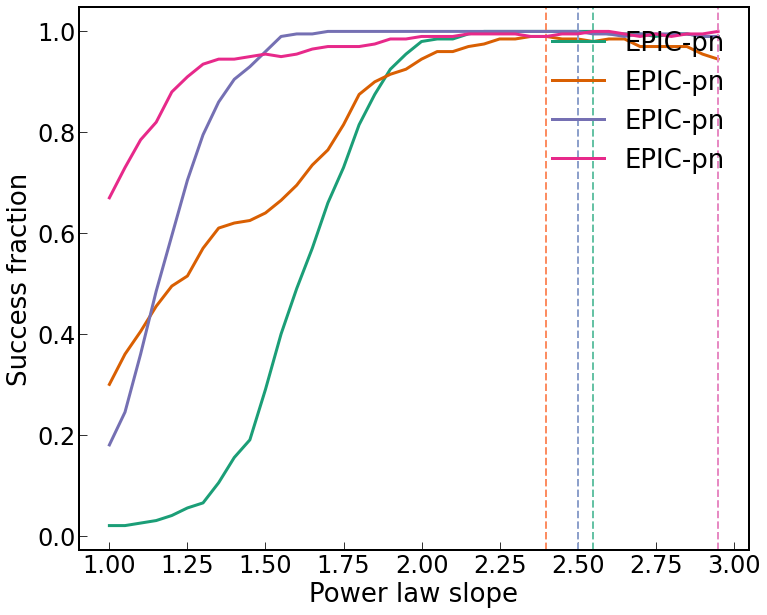

In [19]:
fig,ax=plt.subplots(figsize=(12,10))

for n in range(NoF):
    filename=objct+'/'+paths[n]
    print("Filename:",paths[n])

    time0=np.genfromtxt(filename,usecols=0)
    time=(time0-time0[0])
    flux=np.genfromtxt(filename,usecols=1)
    error=np.genfromtxt(filename,usecols=2)
    N=len(time)

    P,del_t=least_div(time,N)

    total_t=time[-1] - time[0]    
    fmin=1.0/total_t
    fmax=P/(2*total_t)
    
    print("Data size:",N,"Time(in s)",total_t)
    print("Smallest sampling interval(in s)",del_t,"for which the data size is:",P)
    print("-------------------------------------------------------------------------------")
    print(" ")

    del_t=120
    Q,mask,flux_new,time_new=bin_intp(flux,time,del_t)

    if Q%2==0: P=int(Q/2)
    else: P=int((Q-1)/2)

    total_t=time_new[-1] - time_new[0]    
    fmin=1.0/total_t
    fmax=(1.0*P)/total_t
    print("New binned data size:",Q,",New sampling interval(in s)",del_t)
    print("Min frequency(in Hz):",fmin,",Max frequency(in Hz):",fmax)
    
    fgmin=1.0/(M*del_t)
    fgmax=1.0/(2*del_t)

    print("Min frequency(in Hz):",fgmin,",Max frequency(in Hz):",fgmax)
    print("-------------------------------------------------------------------------------")
    print(" ")
    
    freq_gen=np.linspace(fgmin,fgmax,int(M/2))    
    freq=np.linspace(fmin,fmax,P)
    freq_log=np.arange(np.log10(fmin),np.log10(fmax),0.35)
    B=len(freq_log)    
    psd=np.zeros((N_sim+1,P))
    
    
###################################################################
######### Creating an array for linear to log binning #############
###################################################################
    ln2lg=[]
    for j in range(B-1):
        ln2lg.append(np.where((freq>=10**freq_log[j])&(freq<10**freq_log[j+1]))[0])

###################################################################
################# Calculation of Poisson noise ####################
###################################################################
    
    mu_sq=(np.mean(flux))**2 
    poisson_noise=np.mean(np.square(error))/(fmax-fmin)
    poisson_noise_norm=poisson_noise/mu_sq 
    print("Normalised poisson noise:",poisson_noise_norm)

###################################################################
    psd[0,:]=powspec_obs(flux_new,time_new,freq)
    stat0=binmeanstd_1D(psd[0,:],ln2lg,B-1) 
    
    
    #for i in range(bigB): plt.axvline(freq_log[i],color='black') 
    #plt.plot(np.log10(freq),np.log10(psd[0,:]),marker='o')
    #plt.errorbar(freq_log[:-1],stat0[0,:],yerr=stat0[1,:],linestyle='--',marker='o')
    #plt.show()
    
    freq_log+=0.5*(freq_log[1]-freq_log[0])
    
###################################################################
##### Finding the fit parameters for each power law PSD slope #####
###################################################################

    for g in range(K):
        lc_sim=timmkron([pl_ind[g]],freq_gen,mask)
     
        for k in range(1,N_sim+1):  
            psd[k,:]=powspec(lc_sim[k-1,:],time_new,freq)
            #plt.scatter(np.log10(freq),np.log10(psd[k,:]),marker='.',color='black')
    
        psd_log,stat=binmeanstd_2D(psd,ln2lg,B-1)
        '''for k in range(N_sim): plt.plot(freq_log[:-1],psd_log[k,:],color='gray')        
        plt.errorbar(freq_log[:-1],stat[0,:],yerr=stat[1,:],marker='o',linestyle='none')
        plt.show()'''
        
        chisqtor=1e8
        chiguess=np.zeros(J)

        for j in range(J):        
            #chiguess[j]=np.sum(np.square((stat[0,:] + guess[j] - stat0[0,:])/stat[1,:]))
            chiguess[j]=np.sum(np.square( (np.log10(np.power(10,(stat[0,:] + guess[j])) + poisson_noise_norm) - stat0[0,:] )/stat[1,:]))      

        chiguess=chiguess/(B-2) 
        chi[n,0]=np.amin(chiguess)
        normbest=guess[np.argmin(chiguess)]
        
        #plt.plot(guess,chiguess)
        #plt.show()
        
        for k in range(N_sim):              
            chi[n,k+1]=np.sum(np.square((psd_log[k,:] - stat[0,:])/stat[1,:]))
        chi[n,:]=chi[n,:]/(B-2)

        #plt.errorbar(freq_log[:-1],stat0[0,:],yerr=stat0[1,:],linestyle='--',marker='o')
        #plt.errorbar(freq_log[:-1],np.log10(np.power(10,(stat[0,:] + normbest)) + poisson_noise_norm),yerr=stat[1,:],linestyle='none',marker='o')
        #plt.show()  
    
        m=0
        for k in range(1,N_sim+1):     
            if chi[n,0]<chi[n,k]: m+=1
        sucssf[n,g]=(1.0*m)/N_sim
        print('%.3f,%.3f,%.3f' %(pl_ind[g],normbest,sucssf[n,g]))
        if sucssf[n,g]==np.amax(sucssf[n,:]):
            max_ind[n]=pl_ind[g]
            max_mean=np.log10(np.power(10,(stat[0,:] + normbest)) + poisson_noise_norm)
            max_std=stat[1,:]
            max_chi=chiguess
              
###################################################################
########## Saving best fit parameters and plotting ################
###################################################################
     
    hdr[n,:]=fmin,fmax,max_ind[n],np.amax(sucssf[n,:]),chi[n,0],poisson_noise_norm
    toprint=np.column_stack((freq_log[:-1],stat0[0,:],max_mean,max_std))
    np.savetxt(objct+'/psd'+str(n),toprint)

    toprint=np.column_stack((guess,max_chi))
    np.savetxt(objct+'/chinorm'+str(n),toprint)

    ax.set_ylabel('log(PSD)',fontsize=26)
    ax.set_xlabel('log Frequency(Hz) ',fontsize=26)
    ax.errorbar(freq_log[:-1],max_mean,yerr=max_std,ls='none',marker='o',markersize=10,markeredgecolor=c1[n],markerfacecolor=c1[n],ecolor=c1[n])
    ax.plot(freq_log[:-1],stat0[0,:],label=lbl[n],ls='--',lw=3,color=c2[n])
    #ax.axhline(np.log10(poisson_noise_norm),linestyle='-.',color=c2[n])
plt.legend(loc=1,fontsize=16)
plt.show()

toprint=np.vstack((pl_ind,sucssf))
np.savetxt(objct+'/succf',np.transpose(toprint))

fig,ax=plt.subplots(figsize=(12,10))
ax.set_ylabel('Success fraction',fontsize=26)
ax.set_xlabel('Power law slope',fontsize=26)
for n in range(NoF):   
    plt.plot(pl_ind,sucssf[n,:],lw=3,label=lbl[n],color=c1[n])
    plt.axvline(max_ind[n],lw=2,ls='--',color=c2[n])
plt.legend(loc=1,fontsize=26)
plt.show()
#np.savetxt(objct+'details',np.transpose(hdr))